1. Simple Visualization 


2. Data Cleaning


3. Feature Engineering

   3.1 Item Categories
   
   3.2 Shops
   
   3.3 Items
   
   3.4 Merge training and test data
   
   3.5 Sales Lag creation
   
   3.6 Price Trend Lag creation
   
   3.7 Time features creation
   
   
4. Fine tuning and modeling 
   
   4.1 XGBoost
   
   4.2 LightGBM
   
   
5. Fit result plot and Analysis
   

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import itertools
import gc
import tensorflow as tf
import xgboost as xgb
from xgboost import XGBRegressor
import optuna.integration.lightgbm as lgb
import lightgbm as lgbm
import warnings
import shap

pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

# Simple Visualization

In [2]:
ic = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
item = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
shop = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')

In [3]:
shop.shape[0],item.shape[0],ic.shape[0]

(60, 22170, 84)

60 unique shops , 22170 unique items and 84 unique category of items

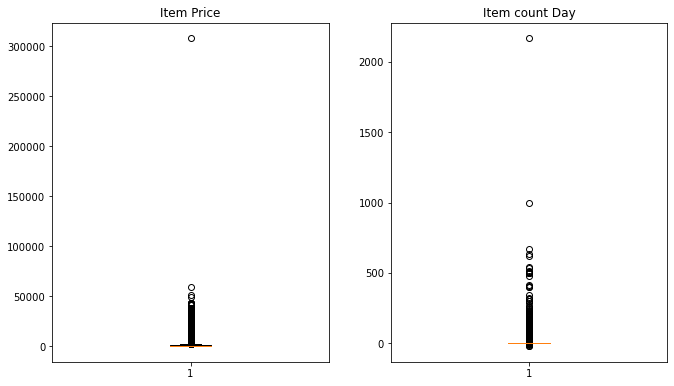

In [4]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.boxplot(train['item_price'])
plt.title('Item Price')
plt.subplot(122)
plt.boxplot(train['item_cnt_day'])
plt.title('Item count Day')
plt.tight_layout(pad=3)
plt.show()

From the box plot, the outlier in item price and item sales number is obvious.

#  Data Cleaning

In [ ]:
train = train[(train['item_price']<10000) & (train['item_cnt_day']<1001)]

In [ ]:
negp = train[train['item_price']<=0]
print(negp)
median = train[(train.shop_id==32)&(train.item_id==2973)&
               (train.date_block_num==4)&(train.item_price>0)]['item_price'].median()
train.loc[train.item_price<0,'item_price'] = median

Use median price to modify the data with negative prices

In [ ]:
train.loc[train.shop_id == 0,'shop_id']=57
test.loc[test.shop_id == 0,'shop_id']=57
train.loc[train.shop_id == 1,'shop_id']=58
test.loc[test.shop_id == 1,'shop_id']=58
train.loc[train.shop_id == 10,'shop_id']=11
test.loc[test.shop_id == 10,'shop_id']=11

Shop name of shop id 0 and 57, 1 and 58, 10 and 11 are the duplicated pairs. So that we should modify it in both training and test dataset

# Feature Engineering

## Item Categories

In [ ]:
ic['split'] = ic['item_category_name'].apply(lambda x: x.split('-'))
ic['type'] = ic['split'].apply(lambda x:x[0].strip())
ic['type_code'] = LabelEncoder().fit_transform(ic['type'])
ic['subtype'] = ic['split'].map(lambda x: x[1].strip() if len(x)>1 else x[0].strip())
ic['subtype_code'] = LabelEncoder().fit_transform(ic['subtype'])
ic = ic[['item_category_id','type_code','subtype_code']]
ic.head()

## Shops

In [ ]:
shop['split'] = shop['shop_name'].apply(lambda x: x.split(' '))
shop['city'] = shop['split'].apply(lambda x: x[0].strip())
shop['city_code'] = LabelEncoder().fit_transform(shop['city'])
shop = shop[['shop_id','city_code']]
shop.head()

## Items

In [ ]:
item.drop(['item_name'],axis=1,inplace=True)
item.head()

## Merge training data and test data

1. shops in training data, but not in test data
2. items in test data, but not in training data

In [ ]:
len(set(test['item_id'])) - len(set(train['item_id']).intersection(set(test['item_id'])))

387 new items found in the test data

In [ ]:
len(set(train['shop_id'])) - len(set(train['shop_id']).intersection(set(test['shop_id'])))

15 shops are not in the test data, but are found in training data

In [ ]:
train = train[train['shop_id'].isin(test.shop_id.unique())]

Drop training data with shops not in test data

In [ ]:
train_match = []
for i in range(34):
    sales = train[train.date_block_num==i]
    train_match.append(np.array(list(itertools.product([i],sales.shop_id.unique(),
                                        sales.item_id.unique())),dtype=np.int16))

train_match = pd.DataFrame(np.vstack(train_match),columns =['date_block_num','shop_id','item_id'])
train_match.sort_values(by = ['date_block_num','shop_id','item_id'],inplace=True)
train_match.head()

Use itertools.product to create all possible (shop,item) pairs in all months

In [ ]:
grouped = train[['date_block_num','shop_id','item_id',
                 'item_cnt_day']].groupby(['date_block_num','shop_id','item_id']).agg('sum')
grouped.columns = ['item_cnt_month']
grouped.reset_index(inplace = True)
train_match = pd.merge(train_match,grouped,on=['date_block_num','shop_id','item_id'],how='left')

train_match['item_cnt_month'] = (train_match['item_cnt_month']
                                 .fillna(0).clip(0,20).astype(np.float16))
train_match.head()

Fill in the created (shop,item) pairs with zero and clip the item_cnt_month into (0,20)

In [ ]:
test['date_block_num'] = 34
train_match = pd.concat([train_match,test],ignore_index=True, axis=0,
                        sort = False,keys = ['date_block_num','shop_id','item_id'])
train_match.fillna(0,inplace=True)
train_match.tail()

Concanate training and test data

In [ ]:
train_match = pd.merge(train_match, item, on=['item_id'], how = 'left')
train_match = pd.merge(train_match, ic, on=['item_category_id'], how = 'left')
train_match = pd.merge(train_match, shop, on=['shop_id'], how='left')
train_match.head()

## Item sales feature engineering

In [ ]:
def create_lag_feature(df,lags,col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for lag in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id',col+'_lag_'+str(lag)]
        ##col value is the timestamp 'lag' (months/date_block_num) before 
        shifted['date_block_num'] += lag
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'],how = 'left')
    
    return df

After adding the value of lag to date_block_num in shifted dataframe and concatenating it with original dataframe, the lag feature is added.

In [ ]:
train_match = create_lag_feature(train_match,[1,2,3,6,12],'item_cnt_month')

In [ ]:
grouped2 = train_match.groupby(['date_block_num']).agg({'item_cnt_month':['mean']})
grouped2.columns = ['avg_item_cnt_month']
grouped2.reset_index(inplace = True)

In [ ]:
train_match = pd.merge(train_match, grouped2, on=['date_block_num'], how='left')
train_match['avg_item_cnt_month'] = train_match['avg_item_cnt_month'].astype('float16')
train_match = create_lag_feature(train_match, [1],'avg_item_cnt_month')
train_match.drop(['avg_item_cnt_month'],axis =1, inplace = True)

In [ ]:
grouped3 = train_match.groupby(['date_block_num','item_id']).agg({'item_cnt_month':['mean']})
grouped3.columns = ['item_avg_item_cnt_month']
grouped3.reset_index(inplace = True)

train_match = pd.merge(train_match, grouped3, on=['date_block_num','item_id'], how ='left')
train_match['item_avg_item_cnt_month'] = train_match['item_avg_item_cnt_month'].astype('float16')
train_match = create_lag_feature(train_match, [1,2,3,6,12], 'item_avg_item_cnt_month')
train_match.drop(['item_avg_item_cnt_month'], axis =1, inplace =True)

In [ ]:
grouped4 = train_match.groupby(['date_block_num','shop_id']).agg({'item_cnt_month':['mean']})
grouped4.columns = ['shop_avg_item_cnt_month']
grouped4.reset_index(inplace = True)

train_match = pd.merge(train_match, grouped4, on=['date_block_num','shop_id'], how ='left')
train_match['shop_avg_item_cnt_month'] = train_match['shop_avg_item_cnt_month'].astype('float16')
train_match = create_lag_feature(train_match, [1,2,3,6,12], 'shop_avg_item_cnt_month')
train_match.drop(['shop_avg_item_cnt_month'], axis =1, inplace =True)

In [ ]:
grouped5 = train_match.groupby(['date_block_num','item_category_id']).agg({'item_cnt_month':['mean']})
grouped5.columns = ['ic_avg_item_cnt_month']
grouped5.reset_index(inplace = True)

train_match = pd.merge(train_match, grouped5, on=['date_block_num','item_category_id'], how ='left')
train_match['ic_avg_item_cnt_month'] = train_match['ic_avg_item_cnt_month'].astype('float16')
train_match = create_lag_feature(train_match, [1], 'ic_avg_item_cnt_month')
train_match.drop(['ic_avg_item_cnt_month'], axis =1, inplace =True)

In [ ]:
grouped6 = train_match.groupby(['date_block_num','type_code']).agg({'item_cnt_month':['mean']})
grouped6.columns = ['type_avg_item_cnt_month']
grouped6.reset_index(inplace = True)

train_match = pd.merge(train_match, grouped6, on=['date_block_num','type_code'], how ='left')
train_match['type_avg_item_cnt_month'] = train_match['type_avg_item_cnt_month'].astype('float16')
train_match = create_lag_feature(train_match, [1], 'type_avg_item_cnt_month')
train_match.drop(['type_avg_item_cnt_month'], axis =1, inplace =True)

In [ ]:
grouped7 = train_match.groupby(['date_block_num','subtype_code']).agg({'item_cnt_month':['mean']})
grouped7.columns = ['subtype_avg_item_cnt_month']
grouped7.reset_index(inplace = True)

train_match = pd.merge(train_match, grouped7, on=['date_block_num','subtype_code'], how ='left')
train_match['subtype_avg_item_cnt_month'] = train_match['subtype_avg_item_cnt_month'].astype('float16')
train_match = create_lag_feature(train_match, [1], 'subtype_avg_item_cnt_month')
train_match.drop(['subtype_avg_item_cnt_month'], axis =1, inplace =True)

In [ ]:
grouped8 = train_match.groupby(['date_block_num','city_code']).agg({'item_cnt_month':['mean']})
grouped8.columns = ['city_avg_item_cnt_month']
grouped8.reset_index(inplace = True)

train_match = pd.merge(train_match, grouped8, on=['date_block_num','city_code'], how ='left')
train_match['city_avg_item_cnt_month'] = train_match['city_avg_item_cnt_month'].astype('float16')
train_match = create_lag_feature(train_match, [1], 'city_avg_item_cnt_month')
train_match.drop(['city_avg_item_cnt_month'], axis =1, inplace =True)

In [ ]:
grouped9 = train_match.groupby(['date_block_num','shop_id','item_category_id']).agg({'item_cnt_month':['mean']})
grouped9.columns = ['shop_ic_avg_item_cnt_month']
grouped9.reset_index(inplace = True)

train_match = pd.merge(train_match, grouped9, on=['date_block_num','shop_id','item_category_id'], how ='left')
train_match['shop_ic_avg_item_cnt_month'] = train_match['shop_ic_avg_item_cnt_month'].astype('float16')
train_match = create_lag_feature(train_match, [1], 'shop_ic_avg_item_cnt_month')
train_match.drop(['shop_ic_avg_item_cnt_month'], axis =1, inplace =True)

In [ ]:
grouped10 = train_match.groupby(['date_block_num','shop_id','type_code']).agg({'item_cnt_month':['mean']})
grouped10.columns = ['shop_type_avg_item_cnt_month']
grouped10.reset_index(inplace = True)

train_match = pd.merge(train_match, grouped10, on=['date_block_num','shop_id','type_code'], how ='left')
train_match['shop_type_avg_item_cnt_month'] = train_match['shop_type_avg_item_cnt_month'].astype('float16')
train_match = create_lag_feature(train_match, [1], 'shop_type_avg_item_cnt_month')
train_match.drop(['shop_type_avg_item_cnt_month'], axis =1, inplace =True)

In [ ]:
grouped11 = train_match.groupby(['date_block_num','shop_id','subtype_code']).agg({'item_cnt_month':['mean']})
grouped11.columns = ['shop_subtype_avg_item_cnt_month']
grouped11.reset_index(inplace = True)

train_match = pd.merge(train_match, grouped11, on=['date_block_num','shop_id','subtype_code'], how ='left')
train_match['shop_subtype_avg_item_cnt_month'] = train_match['shop_subtype_avg_item_cnt_month'].astype('float16')
train_match = create_lag_feature(train_match, [1], 'shop_subtype_avg_item_cnt_month')
train_match.drop(['shop_subtype_avg_item_cnt_month'], axis =1, inplace =True)

In [ ]:
grouped12 = train_match.groupby(['date_block_num','item_id','city_code']).agg({'item_cnt_month':['mean']})
grouped12.columns = ['item_city_avg_item_cnt_month']
grouped12.reset_index(inplace = True)

train_match = pd.merge(train_match, grouped12, on=['date_block_num','item_id','city_code'], how ='left')
train_match['item_city_avg_item_cnt_month'] = train_match['item_city_avg_item_cnt_month'].astype('float16')
train_match = create_lag_feature(train_match, [1], 'item_city_avg_item_cnt_month')
train_match.drop(['item_city_avg_item_cnt_month'], axis =1, inplace =True)

In [ ]:
train_match.columns

In [ ]:
train_match.sample(5)

## Price Trend feature engineering

In [ ]:
grouped13 = train.groupby(['item_id']).agg({'item_price':['mean']})
grouped13.columns = ['item_avg_item_price']
grouped13.reset_index(inplace = True)
train_match = pd.merge(train_match, grouped13, on=['item_id'], how='left')
train_match['item_avg_item_price'] = train_match['item_avg_item_price'].astype('float16')

grouped14 = train.groupby(['date_block_num','item_id']).agg({'item_price':['mean']})
grouped14.columns = ['item_avg_item_price_month']
grouped14.reset_index(inplace = True)
train_match = pd.merge(train_match, grouped14, on=['date_block_num','item_id'], how='left')
train_match['item_avg_item_price_month'] = train_match['item_avg_item_price_month'].astype('float16')

all_lags = [1,2,3,4,5,6]
train_match = create_lag_feature(train_match,all_lags,'item_avg_item_price_month')

In [ ]:
for l in all_lags:
    train_match['delta_price_lag_'+str(l)]= (train_match['item_avg_item_price_month_lag_'+str(l)] - train_match['item_avg_item_price'])/train_match['item_avg_item_price']

def valid_trend(row):
    for l in all_lags:
        if row['delta_price_lag_'+str(l)]:
            return row['delta_price_lag_'+str(l)]
    return 0

train_match['delta_price_lag'] = train_match.apply(valid_trend, axis=1)
train_match['delta_price_lag'] = train_match['delta_price_lag'].astype('float16')
train_match['delta_price_lag'].fillna(0, inplace =True)

to_drop = ['item_avg_item_price','item_avg_item_price_month']
for l in all_lags:
    to_drop += ['item_avg_item_price_month_lag_'+str(l)]
    to_drop += ['delta_price_lag_'+str(l)]
    
train_match.drop(to_drop, axis=1, inplace=True)

Add price fluctuation rate within 6 months. If no fluctuation occurs, fill with zero. If fluctuation occurs, fill with the most recent price fluctuation.

In [ ]:
train_match.columns

## Time features creation

In [ ]:
train_match['month'] = ((train_match['date_block_num']%12)+1).astype('int8')
dof = {1:31, 2:28, 3:31, 4:30, 5:31, 6:30,
       7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
train_match['day'] = train_match['month'].map(dof).astype('int8')

no leap years between 2013-2015

In [ ]:
sale_record = {}
train_match['last_item_sale'] = -1
train_match['last_item_sale'] = train_match['last_item_sale'].astype('int8')
for idx,row in train_match.iterrows():
    key = row.item_id
    if key not in sale_record.keys():
        if row.item_cnt_month != 0:
            sale_record[key] = row.date_block_num
            
    else:
        last_date_block_num = sale_record[key]
        if row.date_block_num > last_date_block_num:
            train_match.at[idx,'last_item_sale'] = row.date_block_num - last_date_block_num
            sale_record[key] = row.date_block_num            

In [ ]:
sale_record = {}
train_match['last_shop_item_sale'] = -1
train_match['last_shop_item_sale'] = train_match['last_shop_item_sale'].astype('int8')
for idx,row in train_match.iterrows():
    key = (row.item_id,row.shop_id)
    if key not in sale_record.keys():
        if row.item_cnt_month != 0:
            sale_record[key] = row.date_block_num
            
    else:
        last_date_block_num = sale_record[key]
        if row.date_block_num > last_date_block_num:
            train_match.at[idx,'last_shop_item_sale'] = row.date_block_num - last_date_block_num
            sale_record[key] = row.date_block_num 

In [ ]:
train_match['first_item_shop_sale'] = train_match['date_block_num'] - train_match.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
train_match['first_item_sale'] = train_match['date_block_num'] -train_match.groupby('item_id')['date_block_num'].transform('min')

transform function works like agg('sum') and merge on (item_id,shop_id)

In [ ]:
train_match = train_match[train_match['date_block_num']>11]

In [ ]:
def fillna_lag(df):
    for col in df.columns:
        if '_lag_' in col and df[col].isnull().any():
            if 'item_cnt' in col:
                df[col].fillna(0, inplace = True)
                
    return df

train_match = fillna_lag(train_match)

In [ ]:
train_match.to_pickle('training.pkl')

In [ ]:
del train_match
del sale_record  
del item
del shop
del ic
del train
del grouped
del grouped2
del grouped3
del grouped4
del grouped5
del grouped6
del grouped7
del grouped8
del grouped9
del grouped10
del grouped11
del grouped12
del grouped13
del grouped14

gc.collect()

In [5]:
training = pd.read_pickle('../input/training-data-for-predicting-fututre-sales/training.pkl')

Split train, test, valid data

In [37]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5443328 entries, 3382199 to 8825526
Data columns (total 39 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   date_block_num                         int64  
 1   shop_id                                int64  
 2   item_id                                int64  
 3   item_cnt_month                         float16
 4   item_category_id                       int64  
 5   type_code                              int64  
 6   subtype_code                           int64  
 7   city_code                              int64  
 8   item_cnt_month_lag_1                   float16
 9   item_cnt_month_lag_2                   float16
 10  item_cnt_month_lag_3                   float16
 11  item_cnt_month_lag_6                   float16
 12  item_cnt_month_lag_12                  float16
 13  avg_item_cnt_month_lag_1               float16
 14  item_avg_item_cnt_month_lag_1          float

In [6]:
train_X = training[training.date_block_num<33].drop(['item_cnt_month'],axis=1)
train_y = training[training.date_block_num<33]['item_cnt_month']
valid_X = training[training.date_block_num==33].drop(['item_cnt_month'],axis=1)
valid_y = training[training.date_block_num==33]['item_cnt_month']
test_X = training[training.date_block_num==34].drop(['item_cnt_month'],axis=1)

# Fine Tuning and Model Fitting

## Xgboost

In [ ]:
max_depth_range = {'max_depth':range(6,10,1)}
cv1 = GridSearchCV(estimator = XGBRegressor(n_estimators = 1000,  
                                            eta = 0.3,
                                            subsample=0.8,
                                            colsample_bytree=0.8,
                                            seed = 0),
                  param_grid = max_depth_range,
                  scoring = 'neg_root_mean_squared_error')

cv1.fit(train_x,train_y)
cv1.cv_results_, cv1.best_score_, cv1.best_params_

GridSearchCV from Scikit-learn is a good tool to do cv and find the good parameters. However, it is too slow because of huge training data.

In [9]:
xgb_params = {'n_estimators':1500, 
             'max_depth':8, 
             'eta':0.1,
             'subsample':0.8,
             'colsample_bytree':0.6,
             'min_child_weight':3,
             'seed':98}

In [10]:
xgb_model = XGBRegressor(**xgb_params)
xgb_model.fit(train_X,train_y,
             eval_metric = 'rmse',
             eval_set = [(train_X, train_y), (valid_X, valid_y)],
             early_stopping_rounds = 10)

[23:06:05] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.16080	validation_1-rmse:1.05665
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.11355	validation_1-rmse:1.02478
[2]	validation_0-rmse:1.07309	validation_1-rmse:0.99147
[3]	validation_0-rmse:1.03922	validation_1-rmse:0.95976
[4]	validation_0-rmse:1.00936	validation_1-rmse:0.93362
[5]	validation_0-rmse:0.98213	validation_1-rmse:0.91111
[6]	validation_0-rmse:0.96160	validation_1-rmse:0.89577
[7]	validation_0-rmse:0.94228	validation_1-rmse:0.88001
[8]	validation_0-rmse:0.92536	validation_1-rmse:0.86701
[9]	validation_0-rmse:0.91112	validation_1-rmse:0.85628
[10]	validation_0-rmse:0.89714	validation_1-rmse:0.84842
[11]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=8,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=0, num_parallel_tree=1, random_state=98,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=98,
             subsample=0.8, tree_method='approx', validate_parameters=1,
             verbosity=None)

In [ ]:
result = xgb_model.predict(test_X).clip(0,20)
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')
submission = pd.DataFrame({'ID':test.index, 'item_cnt_month':result})
submission.to_csv('xgb_submission.csv',index =False)

## LightGBM

In [19]:
cat_features = ['shop_id', 'item_id', 
                'item_category_id', 'type_code', 'subtype_code', 
                'city_code','month']

In [ ]:
dtrain = lgb.Dataset(train_X, label=train_y, categorical_feature=cat_features, free_raw_data=False)
dval = lgb.Dataset(valid_X, label=valid_y, categorical_feature=cat_features, free_raw_data=False)
params = {"objective": "regression","metric": "rmse","verbosity": -1,"boosting_type": "gbdt"}
model = lgb.train(params, dtrain, valid_sets=[dval], verbose_eval=100, early_stopping_rounds=10)

Use integrated fine tuning tools for LightGBM model in optuna

In [ ]:
best_lgbm_params = model.params
best_score = model.best_score
best_lgbm_params,best_score

In [20]:
best_lgbm_params = {'objective': 'regression',
                  'metric': 'rmse',
                  'verbosity': 1,
                  'boosting_type': 'gbdt',
                  'lambda_l1': 4.7870372679959425,
                  'lambda_l2': 2.1719574172416273e-06,
                  'num_leaves': 235,
                  'feature_fraction': 0.5479999999999999,
                  'bagging_fraction': 1.0,
                  'bagging_freq': 0,
                  'min_child_samples': 20}

#X = training[training.date_block_num<34].drop(['item_cnt_month'],axis=1)
#y = training[training.date_block_num<34]['item_cnt_month']

lgbm_model = lgbm.LGBMRegressor(**best_lgbm_params)
lgbm_model.fit(train_X,train_y,
             eval_metric = 'rmse',
             eval_set = [(train_X, train_y), (valid_X, valid_y)],
             early_stopping_rounds = 10, categorical_feature=cat_features)

[1]	training's rmse: 1.14077	valid_1's rmse: 1.0334
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 1.09355	valid_1's rmse: 0.994732
[3]	training's rmse: 1.05412	valid_1's rmse: 0.965153
[4]	training's rmse: 1.01881	valid_1's rmse: 0.938601
[5]	training's rmse: 0.977603	valid_1's rmse: 0.916026
[6]	training's rmse: 0.941426	valid_1's rmse: 0.900013
[7]	training's rmse: 0.916394	valid_1's rmse: 0.881186
[8]	training's rmse: 0.897659	valid_1's rmse: 0.867317
[9]	training's rmse: 0.880669	valid_1's rmse: 0.858149
[10]	training's rmse: 0.86734	valid_1's rmse: 0.847962
[11]	training's rmse: 0.85467	valid_1's rmse: 0.839521
[12]	training's rmse: 0.835282	valid_1's rmse: 0.835916
[13]	training's rmse: 0.817985	valid_1's rmse: 0.831649
[14]	training's rmse: 0.801617	valid_1's rmse: 0.827579
[15]	training's rmse: 0.794033	valid_1's rmse: 0.823134
[16]	training's rmse: 0.780775	valid_1's rmse: 0.821644
[17]	training's rmse: 0.769111	valid_1's rmse: 0.820643
[18]

LGBMRegressor(bagging_fraction=1.0, bagging_freq=0,
              feature_fraction=0.5479999999999999, lambda_l1=4.7870372679959425,
              lambda_l2=2.1719574172416273e-06, metric='rmse', num_leaves=235,
              objective='regression', verbosity=1)

In [31]:
result = lgbm_model.predict(test_X,categorical_feature=cat_features).clip(0,20)
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')
submission = pd.DataFrame({'ID':test.index, 'item_cnt_month':result})
submission.to_csv('lgbm_submission.csv',index =False)

# Fit result plot and Explaination

LightGBM has better performance so I use the fit result of lightgbm to plot the feature importance

Text(0.5, 1.0, 'Feature Importance')

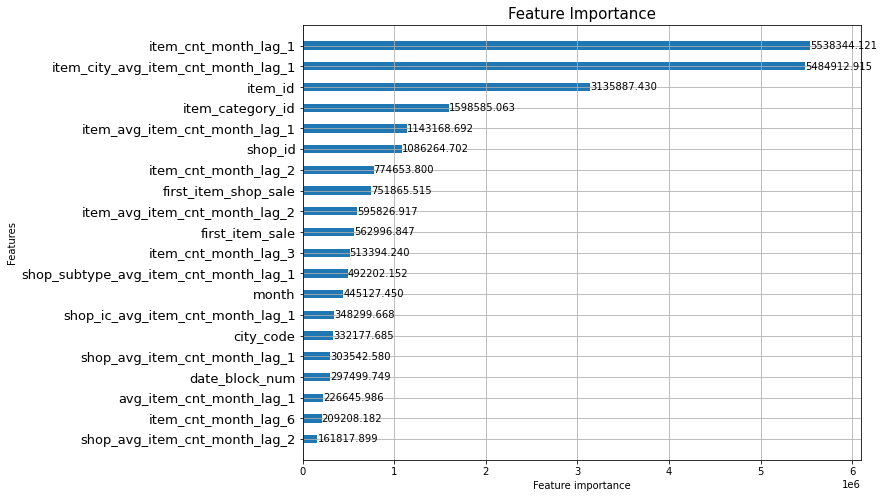

In [30]:
fig,ax = plt.subplots(figsize=(10,8))
lgbm.plot_importance(lgbm_model, height=0.4, max_num_features=20,
                importance_type='gain', ax=ax)
plt.yticks(fontsize=13)
ax.set_title('Feature Importance',fontsize=15)

Feature importance plot only shows how important the feature is during spliting. However, shap values plot can show negative or positive effects of the features on the model.

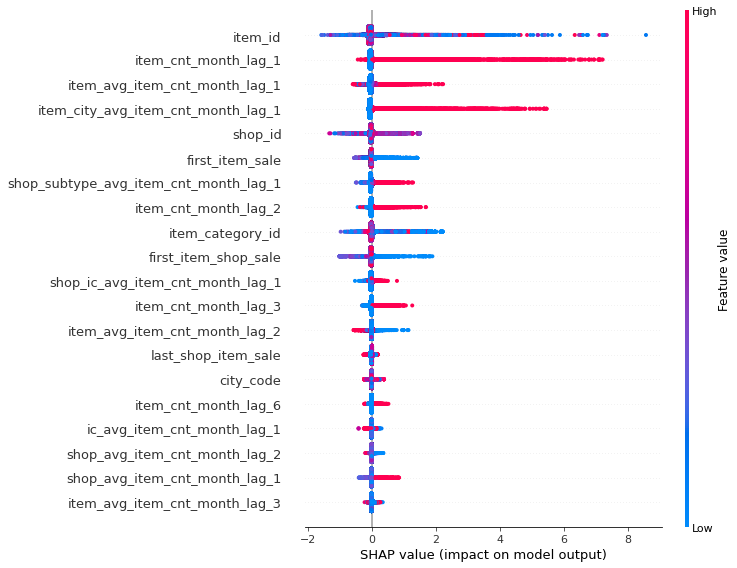

In [24]:
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(valid_X)
shap.summary_plot(shap_values, valid_X, max_display=20)

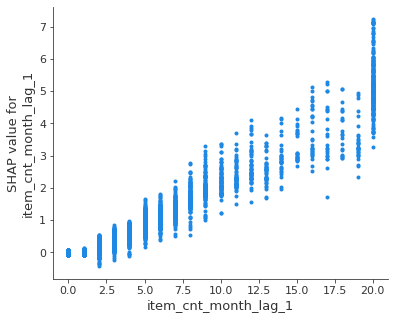

In [33]:
shap.dependence_plot('item_cnt_month_lag_1', shap_values, 
                     valid_X, interaction_index=None, show=False)

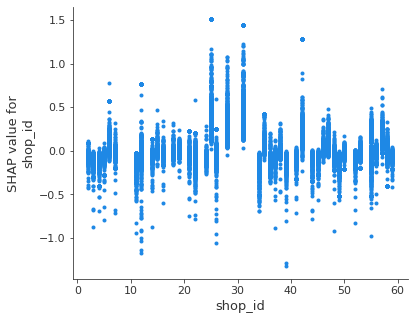

In [36]:
shap.dependence_plot('shop_id', shap_values, 
                     valid_X, interaction_index=None, show=False)

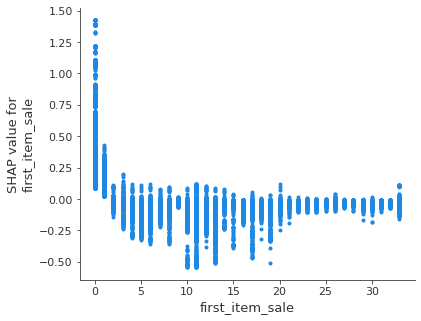

In [35]:
shap.dependence_plot('first_item_sale', shap_values, 
                     valid_X, interaction_index=None, show=False)

1. For most lag features, the larger the feature value, the more positive impacts on model predicting.
2. For categorical features, both large and small feature value can have both positive and negative features impacts on model predicting.
3. For the features which represent months diff towards first item sales records, the smaller the feature value, the more positive impacts on model predicting.

In conclusion, most recent sales record of an item will strongly improve the model predicting.